### Integrated the convex hull generator from points program with the tracking program. Allows isolation of an individual cell (or region) and tracking within it. Parameters will still need modifiying on a case by case basis.

## tidied up version of convex mesh generation code

In [1]:
from skimage import io, data
from skimage import filters, measure
import napari
from scipy import ndimage as ndi
import numpy as np
from PIL import Image
from aicsimageio import AICSImage, imread
import copy
import cv2
from scipy.spatial import ConvexHull, Delaunay
import trackpy as tp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as p
from napari_bleach_correct.modules.exponential import exponential_correct #this must be obtained via downloadin/installing the napari plugin for the napari bleack correct module


In [2]:
viewer = napari.Viewer(title='fast_image_convex_1')

C:\Users\hkqur\miniconda3\envs\devbio_2\lib\site-packages\networkx\utils\backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [4]:
### functions to provide a verbose output. can help to inspect outputs when refining paramaeters or debugging. Sometimes you don't wanto clutter in your notebook output so can turn off outputs.

def verbose_chk():
    verbose_check = input('verbose output? Y/N : ')
    return verbose_check

def isverbose(readout,verbose_check):
    if verbose_check.upper()=='Y':
        output = readout
    else:
        output = None
    return output
    
vb_chk = verbose_chk()

verbose output? Y/N :  y


In [5]:
image_1_name=str('i_ch1')
layer_1_name=image_1_name
image_2_name=str('i_ch2')
layer_2_name=image_2_name
file_dir = str('C:/Users/hkqur/Documents/napari/')
file_path=str('C:/Users/hkqur/Documents/napari/eb3_fast/eb3_nonID-31C_emb3_fast-image_postprojemerg-01-Airyscan Processing-08.czi')

In [6]:
image_i = AICSImage(file_path)
print(image_i.shape)

(32, 1, 78, 588, 332)


In [7]:
i_ch1 = image_i.data[:,0,:,:]
#i_ch2 = image_i.data[:,1,:,:]


In [8]:
viewer.add_image(i_ch1, name='i_ch1',colormap='magenta',blending='additive')
viewer.layers['i_ch1'].scale=[3,1,1]

#viewer.add_image(i_ch2, name='i_ch2',colormap='green',blending='additive')
#viewer.layers['i_ch2'].scale=[6,1,1]


to add here, integrate my image rotation program here so the image can be positioned such that the Apicobasal plane is aligned such that apical faces 'up' in the image viewer. Currently, the program assumes the image is already in the right position. It assumes the apicobasal axis is aligned with the x/y axis. I have already partially generated the code for image rotation to address this, just need to finish it and integrate it.

### convex hull generation

In [9]:
convex_points=viewer.layers['Points'].data

relevant_indices=[1,2,3]
convex_points_3D = [convex_points[i] for i in relevant_indices]

array_3D = []
for a in range(0,len(convex_points)):
    array_3D_element = [convex_points[a][i] for i in relevant_indices]
    print(array_3D_element)
    array_3D.append(array_3D_element)

cell_hull=ConvexHull(array_3D)

cell_convex_test=cell_hull.simplices #generate vertex order of convex hull

surface=viewer.add_surface(data=(convex_points,cell_convex_test)) #cell_convex_test is the points data, convex points is how to join them to create polygon
surface.normals.face.visible = True
surface.normals.vertex.visible = True
surface.wireframe.visible = True

viewer.layers['Surface'].scale=[3,1,1]

#print(cell_hull.volume)

[38.0, 344.3195870353251, 112.92805147084317]
[38.0, 333.1042322846078, 78.58102754677134]
[38.0, 315.5802404866119, 63.860874436454765]
[38.0, 292.4485713132574, 58.2531970610961]
[38.0, 277.027458531021, 68.76759213989362]
[38.0, 267.21402312414335, 103.11461606396551]
[38.0, 257.4005877172657, 129.05012392499935]
[38.0, 249.69003132614748, 159.89234948947205]
[38.0, 258.80250706110536, 177.41634128746796]
[38.0, 274.92457951526154, 194.23937341354394]
[38.0, 293.14953098517725, 201.24897013274233]
[38.0, 309.97256311125324, 201.94992980466213]
[38.0, 324.69271622156975, 183.02401866282662]
[38.0, 335.2071113003673, 161.29426883331178]
[38.0, 341.5157483476458, 135.35876097227788]
[43.0, 354.83398211412265, 111.5261321270035]
[43.0, 337.3099903161268, 77.88006787485148]
[43.0, 320.48695819005076, 58.954156733015964]
[43.0, 293.85049065709705, 54.74839870149697]
[43.0, 270.0178618118227, 54.74839870149697]
[43.0, 247.58715231038795, 69.46855181181348]
[43.0, 235.6708378877508, 85.5906

### create 3D mask from convex hull

In [10]:
conv_points = cell_hull.points

deln = Delaunay(conv_points[cell_hull.vertices])

#print(i_ch1.shape)
i_shape = i_ch1[0,:,:,:]
print(i_shape.shape)

i_shape2 = np.moveaxis(i_shape,0,2)
print(i_shape2.shape)

idx_2d = np.indices(i_shape.shape[1:])
print(idx_2d.shape)
idx_2d = np.moveaxis(idx_2d,0,-1)
print(idx_2d.shape)

#print(i_shape.ndim)
#print(*i_shape.shape)

idx_3d = np.zeros((*i_shape.shape[1:3],i_shape.ndim))
idx_3d.shape
idx_3d[:,:,1:] = idx_2d

mask=np.zeros_like(i_shape,dtype=bool)

#mask.shape
#idx_3d.shape
#len(i_shape)


for z in range(len(i_shape)):
    idx_3d[:,:,0] = z
    s = deln.find_simplex(idx_3d)
    mask[z,(s != -1)] = 1

viewer.add_image(mask, name='mask',colormap='magenta',blending='additive')
viewer.layers['mask'].scale=[3,1,1]


(78, 588, 332)
(588, 332, 78)
(2, 588, 332)
(588, 332, 2)


### crop on mask

In [11]:
#mask.shape
#i_shape.shape
###convert mask from bool to 16bit integer
mask_int = mask*1

masked_crop = np.zeros(i_shape2.shape)
#masked_crop.shape
#i_shape2.dtype
masked_crop = masked_crop.astype(int)
#mask_int.dtype
mask_int_uint = np.uint16(mask_int)
mask_crop_uint = np.uint16(masked_crop)
#mask.shape
#i_ch1.shape

i_ch1_tp0=i_ch1[0,:,:,:]
#i_ch1_tp0 = np.moveaxis(i_ch1_tp0,0,-1)
#i_ch1_tp0.shape
#print('{} = mask_crop_uint  {} = i_ch1_tp0'.format(mask_crop_uint.shape,(np.flip(i_ch1_tp0)).shape))



In [12]:
t_,z_,x_,y_ = i_ch1.shape #extract dimensions
t_

32

In [13]:
i_ch1_copy = copy.deepcopy(i_ch1) #create copy of data

In [14]:
i_ch1_copy[:t_,:,:,:] *=  mask_int_uint #multiply 3D mask array by zyx elements of 4D tzyx array - stepwise C level multiplication of spatial dimensions per t element

In [15]:
print(i_ch1.shape)
print(mask.shape)
print(i_ch1_copy.shape) #check shape is correct

(32, 78, 588, 332)
(78, 588, 332)
(32, 78, 588, 332)


In [16]:
viewer.add_image(i_ch1_copy,name='mask_crop')
viewer.layers['mask_crop'].scale = [3,1,1]

In [215]:
'''
fileID = str(6)
seg_ID = fileID+'_seg'
mask_ID = fileID+'_mask'
maskID_name = 'mask'+fileID

seg_=viewer.layers[seg_ID].data
seg_=seg_*1
skimage.io.imsave('D:/nicole/Fused/D:/nicole/Fused/fusing_myosin-488_ecad647_smad6emb1_immuno_zoom_-01-Airyscan Processing-02/'+seg_ID+'.tiff',seg_)

mask_=viewer.layers[maskID_name].data
mask_=mask_*1
skimage.io.imsave('D:/nicole/Fused/D:/nicole/Fused/fusing_myosin-488_ecad647_smad6emb1_immuno_zoom_-01-Airyscan Processing-02/'+mask_ID+'.tiff',mask_)
'''

"\nfileID = str(6)\nseg_ID = fileID+'_seg'\nmask_ID = fileID+'_mask'\nmaskID_name = 'mask'+fileID\n\nseg_=viewer.layers[seg_ID].data\nseg_=seg_*1\nskimage.io.imsave('D:/nicole/Fused/D:/nicole/Fused/fusing_myosin-488_ecad647_smad6emb1_immuno_zoom_-01-Airyscan Processing-02/'+seg_ID+'.tiff',seg_)\n\nmask_=viewer.layers[maskID_name].data\nmask_=mask_*1\nskimage.io.imsave('D:/nicole/Fused/D:/nicole/Fused/fusing_myosin-488_ecad647_smad6emb1_immuno_zoom_-01-Airyscan Processing-02/'+mask_ID+'.tiff',mask_)\n"

# VECTOR TRACKING

# DEBLEACHING

In [17]:
expon = exponential_correct(i_ch1_copy,contrast_limits=[i_ch1_copy.min(),i_ch1_copy.max()],method='bi') #### run napari-bleach-correct module on eb3-GFP layer, using exponential curve method

09-Nov-24 18:31:05 - napari_bleach_correct.modules.exponential - INFO     - R-squared value for fitting a bi-exponential curve: 0.9997750132700343


In [18]:
viewer.add_image(expon, name = 'debleach',colormap='green',blending='additive')
viewer.layers['debleach'].scale=[3,1,1]

In [19]:
#max_z_fast = viewer.layers[debleach_name].data

# SEGMENTATION

In [50]:
batch_track = tp.batch(expon[:15],diameter=(7,35,35), minmass=10000, separation=(5,13,13), noise_size=(3,4,4), percentile=15) #segmentation code, modify params here for comet detection

Frame 14: 52 features


In [51]:
#batch_track.head
isverbose(batch_track.head, vb_chk)

<bound method NDFrame.head of              z           y           x          mass    size_z     size_y  \
0    34.112942  282.299897  112.042922  1.727882e+06  1.818691  13.573600   
1    34.025301  299.038201  122.471262  1.811889e+06  1.765290  13.284090   
2    38.439427  268.870188   84.808815  3.638594e+05  2.328806   9.309712   
3    38.952808  333.924398  156.962601  2.716908e+06  2.299084   7.479859   
4    42.119625  316.085775   76.561466  1.610176e+06  2.425612  10.228692   
..         ...         ...         ...           ...       ...        ...   
618  69.037339  363.398730  130.827716  6.711914e+05  2.205925   9.047481   
619  71.575750  295.891136  111.946689  4.379873e+05  2.228585  10.273170   
620  73.594951  319.129291  176.069035  5.173189e+05  2.352435  12.536357   
621  72.478194  299.409764  145.061508  2.318019e+05  2.481839   6.543570   
622  73.828958  360.415363  167.576784  8.284718e+05  1.915596  12.937294   

        size_x  ecc       signal    raw_mass 

In [52]:
batch_track2 = batch_track.dropna(axis=1,how='all') #ecc field seems to be returning NaN sometimes, so just in case it does we discard it.
isverbose(batch_track2.head,vb_chk)

<bound method NDFrame.head of              z           y           x          mass    size_z     size_y  \
0    34.112942  282.299897  112.042922  1.727882e+06  1.818691  13.573600   
1    34.025301  299.038201  122.471262  1.811889e+06  1.765290  13.284090   
2    38.439427  268.870188   84.808815  3.638594e+05  2.328806   9.309712   
3    38.952808  333.924398  156.962601  2.716908e+06  2.299084   7.479859   
4    42.119625  316.085775   76.561466  1.610176e+06  2.425612  10.228692   
..         ...         ...         ...           ...       ...        ...   
618  69.037339  363.398730  130.827716  6.711914e+05  2.205925   9.047481   
619  71.575750  295.891136  111.946689  4.379873e+05  2.228585  10.273170   
620  73.594951  319.129291  176.069035  5.173189e+05  2.352435  12.536357   
621  72.478194  299.409764  145.061508  2.318019e+05  2.481839   6.543570   
622  73.828958  360.415363  167.576784  8.284718e+05  1.915596  12.937294   

        size_x       signal    raw_mass      

In [53]:
batch_track3=batch_track2.dropna(axis=0) #once ecc field is dropped we can remove individual rows yielding NaN. dropna will just discard most of the table if we try to do this in one line, as axis=0 will discard everything while ecc is still in (if it is displaying NaN)
isverbose(batch_track3.head,vb_chk)

<bound method NDFrame.head of              z           y           x          mass    size_z     size_y  \
0    34.112942  282.299897  112.042922  1.727882e+06  1.818691  13.573600   
1    34.025301  299.038201  122.471262  1.811889e+06  1.765290  13.284090   
2    38.439427  268.870188   84.808815  3.638594e+05  2.328806   9.309712   
3    38.952808  333.924398  156.962601  2.716908e+06  2.299084   7.479859   
4    42.119625  316.085775   76.561466  1.610176e+06  2.425612  10.228692   
..         ...         ...         ...           ...       ...        ...   
618  69.037339  363.398730  130.827716  6.711914e+05  2.205925   9.047481   
619  71.575750  295.891136  111.946689  4.379873e+05  2.228585  10.273170   
620  73.594951  319.129291  176.069035  5.173189e+05  2.352435  12.536357   
621  72.478194  299.409764  145.061508  2.318019e+05  2.481839   6.543570   
622  73.828958  360.415363  167.576784  8.284718e+05  1.915596  12.937294   

        size_x       signal    raw_mass      

C:\Users\hkqur\miniconda3\envs\devbio_2\lib\site-packages\trackpy\plots.py:638: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  axlist = f[pos_columns].applymap(lambda x: x % 1).hist()


array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'y'}>],
       [<Axes: title={'center': 'z'}>, <Axes: >]], dtype=object)

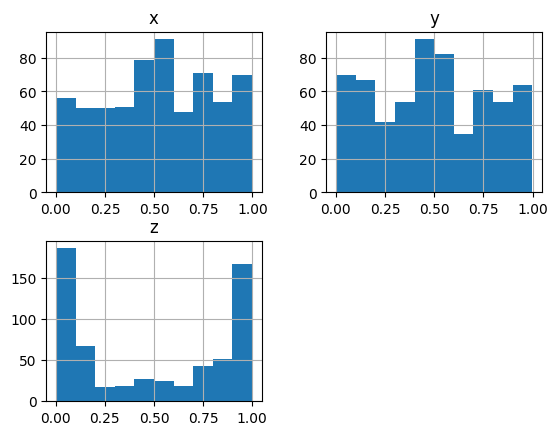

In [54]:
tp.subpx_bias(batch_track)

(array([81.,  3.,  6.,  8., 38., 55., 58., 67., 70., 62., 31., 38., 37.,
        19.,  7.,  9.,  8., 10.,  5.,  5.]),
 array([       0. ,  1418133.3,  2836266.6,  4254399.9,  5672533.2,
         7090666.5,  8508799.8,  9926933.1, 11345066.4, 12763199.7,
        14181333. , 15599466.3, 17017599.6, 18435732.9, 19853866.2,
        21271999.5, 22690132.8, 24108266.1, 25526399.4, 26944532.7,
        28362666. ]),
 <BarContainer object of 20 artists>)

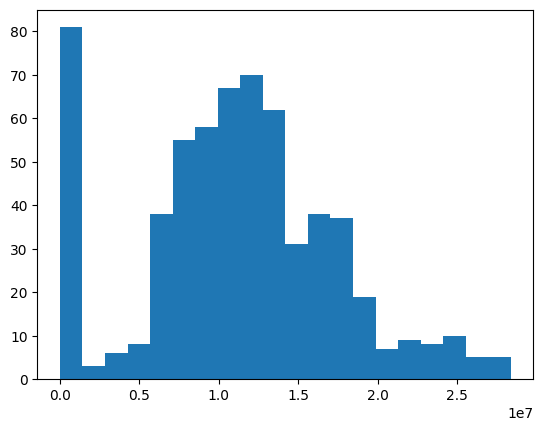

In [55]:
fig,ax=plt.subplots()
ax.hist(batch_track3['raw_mass'], bins=20)

In [56]:
isverbose(batch_track3.columns,vb_chk) #inspecting reworked dataframe with NaN;s removed. Most columns should still be here.

Index(['z', 'y', 'x', 'mass', 'size_z', 'size_y', 'size_x', 'signal',
       'raw_mass', 'ep_z', 'ep_y', 'ep_x', 'frame'],
      dtype='object')

In [57]:
batch_track3['id'] = np.arange(0,len(batch_track3))

C:\Users\hkqur\AppData\Local\Temp\ipykernel_24392\1072258347.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_track3['id'] = np.arange(0,len(batch_track3))


In [58]:
batch_track_reorg=batch_track3[["id","frame","z","y","x"]]

In [59]:
isverbose(batch_track_reorg.head,vb_chk)

<bound method NDFrame.head of       id  frame          z           y           x
0      0      0  34.112942  282.299897  112.042922
1      1      0  34.025301  299.038201  122.471262
2      2      0  38.439427  268.870188   84.808815
3      3      0  38.952808  333.924398  156.962601
4      4      0  42.119625  316.085775   76.561466
..   ...    ...        ...         ...         ...
618  612     14  69.037339  363.398730  130.827716
619  613     14  71.575750  295.891136  111.946689
620  614     14  73.594951  319.129291  176.069035
621  615     14  72.478194  299.409764  145.061508
622  616     14  73.828958  360.415363  167.576784

[617 rows x 5 columns]>

# TRACKING

In [60]:
trax = tp.link(batch_track_reorg,search_range=(5,15,15),memory=5) #increasing the range and memory can help produce more positive tracks, especially in the x,y axes where the resolution is quite high. This repersents the radius within which to look for the next hit in the track.

Frame 14: 52 trajectories present.


In [61]:
isverbose(trax.head,vb_chk)

<bound method NDFrame.head of       id  frame          z           y           x  particle
0      0      0  34.112942  282.299897  112.042922         0
26    26      0  73.894076  259.551521  104.827575         1
25    25      0  66.868560  314.908397   65.860692         2
24    24      0  63.971492  297.919275  116.981783         3
23    23      0  58.938333  332.761885   63.189055         4
..   ...    ...        ...         ...         ...       ...
591  585     14  53.993454  293.565839   51.201742         6
592  586     14  53.937841  302.576883  159.871998        93
593  587     14  54.012596  317.421489  207.579473        52
595  589     14  54.987999  246.923838   97.590106        11
622  616     14  73.828958  360.415363  167.576784       109

[617 rows x 6 columns]>

In [62]:
trax_filter=tp.filter_stubs(trax,4)
isverbose(trax_filter.columns,vb_chk)

Index(['id', 'frame', 'z', 'y', 'x', 'particle'], dtype='object')

In [63]:
trax_filter_reorg = trax_filter[['particle','frame','z','y','x']]

In [76]:
viewer.add_tracks(trax_filter_reorg,name='tracks_T')
viewer.layers['tracks_T'].scale=[3,1,1]

C:\Users\hkqur\miniconda3\envs\devbio_2\lib\site-packages\vispy\visuals\mesh_normals.py:129: RuntimeWarning: invalid value encountered in divide
  unit_normals = normals / norms
C:\Users\hkqur\miniconda3\envs\devbio_2\lib\site-packages\vispy\visuals\mesh_normals.py:129: RuntimeWarning: invalid value encountered in divide
  unit_normals = normals / norms
C:\Users\hkqur\miniconda3\envs\devbio_2\lib\site-packages\vispy\visuals\mesh_normals.py:129: RuntimeWarning: invalid value encountered in divide
  unit_normals = normals / norms
C:\Users\hkqur\miniconda3\envs\devbio_2\lib\site-packages\vispy\visuals\mesh_normals.py:129: RuntimeWarning: invalid value encountered in divide
  unit_normals = normals / norms
C:\Users\hkqur\miniconda3\envs\devbio_2\lib\site-packages\vispy\visuals\mesh_normals.py:129: RuntimeWarning: invalid value encountered in divide
  unit_normals = normals / norms


# VECTOR GENERATION

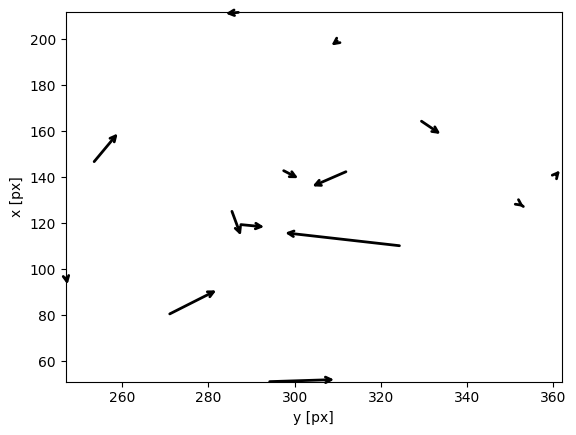

In [65]:
track_vector=tp.plot_displacements(trax_filter,1,14,pos_columns=['y','x'])

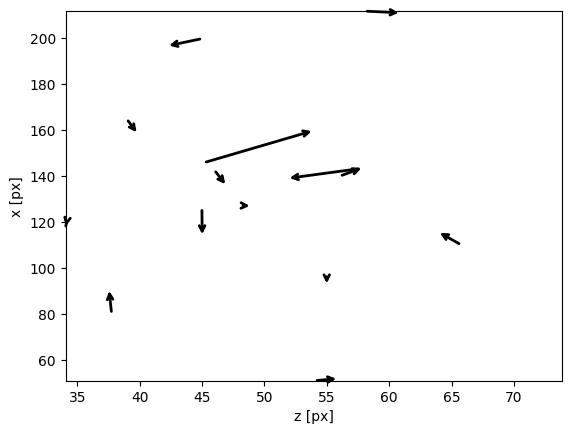

In [66]:
track_vector=tp.plot_displacements(trax_filter,1,14,pos_columns=['z','x'])

In [67]:
#t_filter.to_csv('plot_tracks.csv')
#print(t_filter)
#t_filter[:2]

In [68]:
firstgrouped_tfilter = trax_filter.groupby("particle").first()
isverbose(firstgrouped_tfilter.head,vb_chk)

<bound method NDFrame.head of            id  frame          z           y           x
particle                                               
1          26      0  73.894076  259.551521  104.827575
3          24      0  63.971492  297.919275  116.981783
4          23      0  58.938333  332.761885   63.189055
5          21      0  57.978589  362.580267  147.422219
6          20      0  55.986111  311.004577   51.841929
...       ...    ...        ...         ...         ...
93        321      8  55.010939  308.365905  170.632412
96        316      8  51.011014  249.970823  122.639385
97        374      9  61.930998  357.352131  170.706918
104       420     10  63.836357  266.298108   71.818719
106       391     10  38.983036  276.685600  187.963319

[64 rows x 5 columns]>

In [69]:
#firstgrouped_tfilter.to_csv('firstinstance_grouped_tracks.csv') #writing df to csv to inspect how the df is organised. Dev auditing step, not a necessary step for function.

In [70]:
lastgrouped_tfilter = trax_filter.groupby("particle").last()
isverbose(lastgrouped_tfilter.head,vb_chk)

<bound method NDFrame.head of            id  frame          z           y           x
particle                                               
1         553     13  64.845937  252.141260   99.151918
3         610     14  65.781275  324.937450  110.134947
4         289      7  61.902465  324.425384   60.778783
5         592     14  56.009071  360.188375  140.017738
6         585     14  53.993454  293.565839   51.201742
...       ...    ...        ...         ...         ...
93        586     14  53.937841  302.576883  159.871998
96        442     11  52.989765  248.971000  115.617474
97        496     12  57.031822  355.033745  162.593765
104       605     14  61.892245  264.029642   67.362042
106       568     14  38.943770  289.353954  194.185070

[64 rows x 5 columns]>

In [71]:
vector_list=[]
for a in range(0,len(lastgrouped_tfilter)-1):
    vector_start = np.array([firstgrouped_tfilter.iloc[a]['z'],firstgrouped_tfilter.iloc[a]['y'],firstgrouped_tfilter.iloc[a]['x']])
    vector_end = np.array([lastgrouped_tfilter.iloc[a]['z'],lastgrouped_tfilter.iloc[a]['y'],lastgrouped_tfilter.iloc[a]['x']]) #extract start and end point of vector to set up projection calculation
    vector_direction = vector_end - vector_start

    vector_total = [vector_start,vector_direction]
    vector_list.append(vector_total)
    

In [72]:
vector_array=np.asarray(vector_list, dtype=np.float32)
isverbose(vector_array.shape,vb_chk)

(63, 2, 3)

In [73]:
isverbose(vector_array[:10],vb_chk)

array([[[ 73.89407   , 259.5515    , 104.827576  ],
        [ -9.04814   ,  -7.410261  ,  -5.6756573 ]],

       [[ 63.971493  , 297.91928   , 116.98178   ],
        [  1.8097829 ,  27.018175  ,  -6.846836  ]],

       [[ 58.93833   , 332.76187   ,  63.189056  ],
        [  2.9641323 ,  -8.336501  ,  -2.4102716 ]],

       [[ 57.97859   , 362.58026   , 147.42223   ],
        [ -1.9695182 ,  -2.3918924 ,  -7.404481  ]],

       [[ 55.98611   , 311.00458   ,  51.84193   ],
        [ -1.9926572 , -17.438738  ,  -0.6401865 ]],

       [[ 54.725403  , 309.5792    , 144.62463   ],
        [  3.0271254 , -12.69721   ,  -1.2136325 ]],

       [[ 54.03268   , 340.54913   , 185.57657   ],
        [  6.918985  ,  -4.2831163 ,  12.993648  ]],

       [[ 53.00566   , 267.30493   ,  61.977886  ],
        [  0.9865225 ,   3.814412  ,  -5.6293445 ]],

       [[ 52.023865  , 259.922     , 164.71768   ],
        [ -6.9001493 ,  -6.8305435 , -18.857634  ]],

       [[ 52.003483  , 246.34818   ,  93.34738

In [75]:
vectors_layer = viewer.add_vectors(vector_array, edge_width=3,name='vectors_layer')
viewer.layers['vectors_layer'].scale=[3,1,1]

# VECTOR ANGLE CALCULATION

In [243]:
#functions to compare vector angles. compare direction vectors.
def unit_vector(vector):    #Returns the unit vector of the vector  
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2): #Returns the angle in radians between vectors 'v1' and 'v2'

    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [244]:
def angle_between_vectors_cross(u, v):
    """
    Calculate the angle between two vectors using the cross product.

    Parameters:
    u, v : array-like
        Input vectors.

    Returns:
    tuple
        The angle between the vectors in radians and degrees.
    """
    u = np.array(u)
    v = np.array(v)
    
    cross_product = np.cross(u, v)
    magnitude_u = np.linalg.norm(u)
    magnitude_v = np.linalg.norm(v)
    magnitude_cross = np.linalg.norm(cross_product)
    
    sin_theta = magnitude_cross / (magnitude_u * magnitude_v)
    sin_theta = np.clip(sin_theta, -1.0, 1.0)  # Ensure sin_theta is within the valid range
    
    angle_radians = np.arcsin(sin_theta)
    angle_degrees = np.degrees(angle_radians)
    
    #return angle_radians, angle_degrees
    return angle_degrees

In [140]:
def vector_angle_tan(u,v):
    vec_dot = np.dot(u,v)
    vec_magnitude_u = np.linalg.norm(u)
    vec_magnitude_v = np.linalg.norm(v)
    vec_cosine = np.arccos(vec_dot/(vec_magnitude_u * vec_magnitude_v))
    vec_cross = np.cross(u,v)
    vec_cross_magnitude = np.linalg.norm(vec_cross)
    #vec_3d_sine = np.arcsine(vec_cross_magnitude/(vec_magnitude_u * vec_magnitude_v))
    vec_tan_angle = np.arctan2(vec_cross_magnitude,vec_dot)
    return vec_tan_angle

## Manually input points defining start and end of axis. 
start from apex

In [245]:
central_line=viewer.layers['Points'].data

In [246]:
central_line_3d=np.delete(central_line,0,axis=1)


In [247]:
isverbose(central_line,vb_chk)

array([[  0.        ,  65.        , 361.70344868, 129.1959463 ],
       [  0.        ,  65.        , 367.59059463, 335.24605452]])

In [248]:
central_line_dir_vector=central_line_3d[0]-central_line_3d[1] #because I drew the points in 'reverse order' where I draw set the basal point as vector start, I've inverted how I usually calculate my direction vector. That way, we count clockwise from apical point (in this specific image, anyway. Always check thet order in which you lay down the central line points when doing it manually in napari.

In [249]:
angles_from_central=[]
for b in range(0,len(vector_array)-1):
    track_vector_angle_dir=vector_array[:,1][b]
    angle_from = angle_between(central_line_dir_vector,track_vector_angle_dir)
    angles_from_central.append(angle_from)

### experimental

In [153]:
vector_array[:,1][1]

array([ 5.9684615, 12.705724 , -8.731874 ], dtype=float32)

In [141]:
### using atan2 to get 2pi angles
angles_from_central_atan2=[]
for b in range(0,len(vector_array)-1):
    track_vector_angle_dir_atan2=vector_array[:,1][b]
    angle_from_atan2 = vector_angle_tan(central_line_dir_vector,track_vector_angle_dir_atan2)
    angles_from_central_atan2.append(angle_from_atan2)

In [159]:
#get vector plane
'''def get_plane_equation_from_points(P, Q, R):  
    x1, y1, z1 = P
    x2, y2, z2 = Q
    x3, y3, z3 = R
    a1 = x2 - x1 
    b1 = y2 - y1 
    c1 = z2 - z1 
    a2 = x3 - x1 
    b2 = y3 - y1 
    c2 = z3 - z1 
    a = b1 * c2 - b2 * c1 
    b = a2 * c1 - a1 * c2 
    c = a1 * b2 - b1 * a2 
    d = (- a * x1 - b * y1 - c * z1) 
    return a, b, c, d
'''
#normal vector to a plane is calculated from the cross product of 2 vectors on the plane
#get normal to plane the apex and track lie on
def angle_between_vectors_plane(u,v):
    dot_prod_vec = np.dot(u,v)
    plane_normal = np.cross(central_line_dir_vector,track_vector_angle_dir_atan2) #cross product of apical vector vs track vector remember cross product is non commutable
    w =np.linalg.norm(plane_normal) #normalise plane normal to give it unit length - plane_normal_normalise
    #determinant = x1*y2*zn + x2*yn*z1 + xn*y1*z2 - z1*y2*xn - z2*yn*x1 - zn*y1*x2
    determinant = u[0]*v[1]*w[2] +  u[1]*v[2]*w[0] +  u[2]*v[0]*w[1] - w[0]*v[1]*u[2] - w[1]*v[2]*u[0] - w[2]*v[0]*u[1]
    tan2_angle = np.arctan2(determinant,dot_prod_vec)
    return tan2_angle

In [160]:
### cross product
angles_from_central_plane=[]
for b in range(0,len(vector_array)-1):
    track_vector_angle_dir_plane=vector_array[:,1][b]
    angle_from_plane = angle_between_vectors_plane(central_line_dir_vector,track_vector_angle_dir_plane)
    angles_from_central_plane.append(angle_from_plane)

In [161]:
angles_from_central_plane

[1.5759392879252985,
 -1.5699475749929777,
 -1.5643914360842786,
 -1.5722512141428393,
 1.5732750934418942,
 -1.572673917329092,
 1.7246676120189388,
 -1.5727789774682424,
 -1.567918306176548,
 1.5719376223489716,
 1.5442645620026758,
 1.5708472790181005,
 1.5747714911817507,
 -1.5718658542056112,
 -1.5704899963949908,
 1.5698380634111835,
 -1.5703341425112736,
 1.56997832881086,
 -1.5722326024438262,
 -1.5693070192694436,
 1.5731090995776351,
 1.571919662844638,
 -1.595709727972235,
 -1.567148745246799,
 1.5808742195281633,
 -1.553941386530685,
 1.5730258720634847,
 1.5426334121119407,
 1.5734772623899134,
 1.5839422607800364,
 1.5770894263240391,
 -1.5576556289813144,
 -1.574723029476472,
 1.56865514820246,
 -1.5892556897291863,
 -1.5732464874608632,
 1.576399604531526,
 1.5720600870524455,
 1.6212527613214303,
 1.5729955366586432,
 1.5687556910296068,
 -1.570099969747301,
 -1.5679828455506999,
 1.57085600672985,
 -1.574264836360263,
 1.569843691157042,
 -1.577746577404953,
 -1.56344

In [130]:
angles_from_central_CROSS

[25.25784311603504,
 65.80461142482119,
 22.447700722097938,
 54.21281023870456,
 43.37199810624887,
 51.83306603864632,
 10.71162336844682,
 60.46755549827234,
 33.38068315371682,
 76.32633577121474,
 4.56475975882683,
 88.80413224470921,
 39.565787897090196,
 66.32488784569267,
 82.84278253413993,
 73.31554973114451,
 76.82933995455302,
 66.55691246415724,
 54.68427589184764,
 51.35299677088879,
 47.84450051469109,
 66.92854058506032,
 13.691744274213931,
 50.20944323695019,
 10.57385282594073,
 11.092134425791372,
 52.15118589330344,
 4.243277721464951,
 61.733578838908066,
 10.316198549439498,
 29.949545402259847,
 7.816259020757979,
 35.910320766455065,
 56.49924060916643,
 9.473437449013192,
 38.08807986155062,
 36.636225949244576,
 70.61857921930157,
 13.632323751568808,
 48.002451254714224,
 43.33958974745106,
 72.1353584947892,
 35.78038910855774,
 88.59541505047865,
 27.890926611553564,
 68.65104728254059,
 24.86805524986601,
 21.607728999654118,
 56.49455400274629,
 64.45887

In [250]:
#create dataframe out of angles and export to csv
export_angles_dataframe=pd.DataFrame(angles_from_central,columns=['angles'])
export_angles_dataframe.to_csv('mitosis_vector_angles_cell_2.csv')

C:\Users\hkqur\miniconda3\envs\napdevbio\lib\site-packages\vispy\visuals\mesh_normals.py:129: RuntimeWarning: invalid value encountered in divide
  unit_normals = normals / norms


In [143]:
### atan2 method
#create dataframe out of angles and export to csv
export_angles_dataframe=pd.DataFrame(angles_from_central_atan2,columns=['angles'])
export_angles_dataframe.to_csv('mitosis_vector_atan2_angles_cell1.csv')

In [162]:
### plane method
#create dataframe out of angles and export to csv
export_angles_dataframe=pd.DataFrame(angles_from_central_plane,columns=['angles'])
export_angles_dataframe.to_csv('mitosis_vector_plane_angles_cell1.csv')

Rendering frames...


100%|████████████████████████████████████████████████████████████████████████████████| 136/136 [00:08<00:00, 16.41it/s]


Rendering frames...


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:04<00:00, 16.91it/s]
C:\Users\hkqur\miniconda3\envs\napdevbio\lib\site-packages\vispy\visuals\mesh_normals.py:129: RuntimeWarning: invalid value encountered in divide
  unit_normals = normals / norms


Rendering frames...


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:04<00:00, 15.38it/s]


Rendering frames...


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:02<00:00, 16.92it/s]


Rendering frames...


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:04<00:00, 14.16it/s]
08-Nov-24 13:55:21 - vispy    - WARNING  - Error drawing visual <Image at 0x230ca2c2f70>
08-Nov-24 13:55:21 - vispy    - WARNING  - Error drawing visual <Image at 0x230ca2c2f70>
08-Nov-24 13:55:21 - vispy    - WARNING  - Error drawing visual <Image at 0x230ca2c2f70>
08-Nov-24 13:55:21 - vispy    - WARNING  - Error drawing visual <Image at 0x230ca2c2f70>
08-Nov-24 13:55:21 - vispy    - WARNING  - Error drawing visual <Image at 0x230ca2c2f70>
08-Nov-24 13:55:21 - vispy    - WARNING  - Error drawing visual <Image at 0x230ca2c2f70>
08-Nov-24 13:55:21 - vispy    - WARNING  - Error drawing visual <Image at 0x230ca2c2f70>
08-Nov-24 13:55:21 - vispy    - WARNING  - Error drawing visual <Image at 0x230ca2c2f70>
08-Nov-24 13:55:21 - vispy    - WARNING  - Error drawing visual <Image at 0x230ca2c2f70>
08-Nov-24 13:55:21 - vispy    - WARNING  - Error drawing visual <Image at 0x230

appraising start and end point of random track

In [146]:
points = np.array([vector_start, vector_end])



In [147]:
points_layer = viewer.add_points(points, size=30)

In [148]:
viewer.layers['points'].scale=[3,1,1]

In [151]:
vector_array[:,1][0]

array([-0.01189825, -1.5442965 ,  5.1051106 ], dtype=float32)